# Objective
# Develop an algorithm to determine all vessel proximity events (two vessels having different MMSIs come within a threshold distance) during a given time frame. 

# Data provided
# A CSV sample  file with position coordinates (latitude and longitude), respective timestamp and Maritime Mobile Service Identity (MMSI) number for all vessels, is provided by the client.

In [2]:
#importing libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
import math
import time
import plotly.express as px
import plotly.graph_objects as go

In [3]:
#reading csv file in the form of dataframe
data=pd.read_csv(r"C:\Users\ASUS\Downloads\sample_data (1).csv")
data

,mmsi,timestamp,lat,lon
0,565761000,2023-03-15 00:27:44+00,1.268780,103.758270
1,538008084,2023-03-19 23:30:00+00,43.559620,10.294040
2,564654000,2023-03-12 08:22:53+00,1.237250,103.891350
3,529123000,2023-03-05 16:47:42+00,29.443670,48.930660
4,564780000,2023-03-11 06:35:20+00,1.277550,103.610260
...,...,...,...,...
13496,218719092,2023-03-21 08:30:00+00,44.168871,9.104404
13497,564654000,2023-03-13 22:42:16+00,1.257010,103.841010
13498,564654000,2023-03-05 10:15:11+00,1.280430,103.907730
13499,565761000,2023-03-19 07:30:00+00,1.302624,103.951899


In [4]:
# Format correction for timestamp column
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Haversine formula
# It is used to compute two distance on sphere using latitude and longitude.

In [5]:
#Defining a function for Haversine formula
def vectorized_haversine(lon1, lat1, lon2, lat2):
    R = 6371000  # radius of Earth in meters
    
    #Converting values into radians for calculating distance over sphere
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    meters = R * c  # output distance in meters
    return meters

# Approach
# To find the vessel proximity event, first aim is to find vessels having the same timestamps. Once these vessels are found (all having different MMSI numbers), the Haversine distance can be calculated based on provided latitude and longitude. Once the distance becomes less than a particular threshold, that event becomes tha "vessel proximity event"   

In [ ]:
# Define the proximity threshold in kilometers
threshold_distance = 60 #Threshold in meters (Source:https://www.nsw.gov.au/driving-boating-and-transport/waterways-safety-and-rules/rules/safe-distance)

# Convert lat and lon to numpy arrays
lats = data['lat'].to_numpy()
lons = data['lon'].to_numpy()
timestamps = data['timestamp'].to_numpy()
mmsis = data['mmsi'].to_numpy()

# Initializing list for proximity events
proximity_events = []

start_time = time.time()

# Comparing each pair of vessels; Only when mmsi number is different for two vessels, then the code proceeds
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        if mmsis[i] != mmsis[j]:
            # Filtering by timestamps; when it matches, the haverside distace is calculated
            if timestamps[i] == timestamps[j]: 
                dist = vectorized_haversine(lats[i], lons[i], lats[j], lons[j])
                #To check when two vessels are at a distance less than the threshold
                if dist < threshold_distance:
                    proximity_events.append({
                        'mmsi': mmsis[i],
                        'vessel_proximity': mmsis[j],
                        'timestamp': timestamps[i]
                    })

end_time = time.time()

print(f"Elapsed time: {end_time - start_time:.2f} seconds")
print(f"Number of proximity events: {len(proximity_events)}")

# Converting vessel proximity events to DataFrame
proximity_df = pd.DataFrame(proximity_events)
proximity_df.to_csv('proximity_data.csv', index=False)
proximity_df

In [ ]:

merged_df = pd.merge(proximity_df, data, how='left', left_on=['mmsi', 'timestamp'], right_on=['mmsi', 'timestamp'], suffixes=('', '_main'))

# Create a new DataFrame for the proximity vessel
new_df = proximity_df[['vessel_proximity', 'timestamp']].rename(columns={'vessel_proximity': 'mmsi'})

# Merge the new DataFrame with data to get latitude and longitude for the proximity vessel
merged_df2 = pd.merge(new_df, data, how='left', left_on=['mmsi', 'timestamp'], right_on=['mmsi', 'timestamp'], suffixes=('', '_proximity'))

In [ ]:
merged_df2

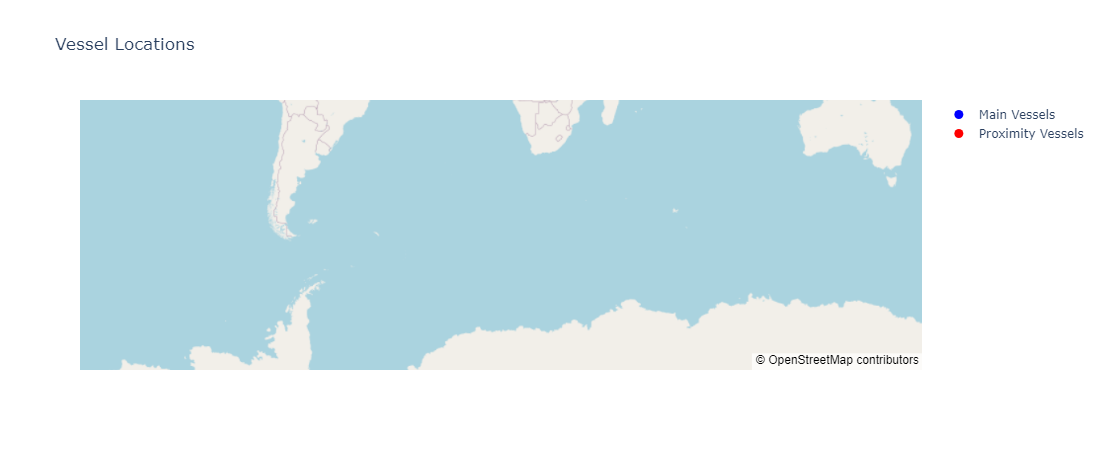

In [19]:
fig = go.Figure()

# Adding scatter plot for main vessels
fig.add_trace(go.Scattermapbox(
    mode="markers",
    lon=merged_df['lon'],
    lat=merged_df['lat'],
    marker=dict(size=9, color='blue'),
    text=final_merged_df['mmsi_main_vessel'],
    name="Main Vessels"
))

# Adding scatter plot for proximity vessels
fig.add_trace(go.Scattermapbox(
    mode="markers",
    lon=merged_df2['lon'],
    lat=merged_df2['lat'],
    marker=dict(size=9, color='red'),
    text=final_merged_df['mmsi_proximity_vessel'],
    name="Proximity Vessels"
))

# Setting map style
fig.update_layout(
    mapbox_style="open-street-map",
    showlegend=True,
    title="Vessel Locations"
)

# Showing the plot
fig.show()#The plots needs to be zoomed in to view both the main and proximity vessel (as the distance is very close)